# Derivation of the Method

We will define the regularized adaptive moments over multiple bands with a Gaussian PSFs as the set of parameters $\{A_k,\mu,\mathbf{M}\}$ that minimize

$$
E = \frac{1}{2}\sum_k \frac{|J_k|}{\sigma_{I,k}^2}\int dx^2 \left(I_k(x) - A_k w_k(x)\right)^2 + \frac{1}{2}\frac{\mu^T\mu}{\sigma_\mu^2} + \frac{\nu + 3}{2}\ln|\mathbf{M} + \mathbf{P}_{\rm min}| + \frac{1}{2}\text{Tr}\left((\mathbf{M} + \mathbf{P}_{\rm min})^{-1}\mathbf{C}\right)
$$

where $w_k(x)$ is 

$$
w_k(x) = \exp\left(-\frac{1}{2}(x-\mu)^T(\mathbf{M} + \mathbf{P}_k)^{-1}(x-\mu)\right)\ .
$$

The various quantities are define as follows:

- $I_k(x)$ is the $k$-th image surface brightness
- $\sigma_{I,k}$ is the noise level in the $k$-th image's flux in a given pixel
- $|J_k|$ is the determinant of the Jacobian of the $k$-th image (i.e., the area of the pixel in the $k$-th image)
- $\mathbf{P}_k$ is the covariance matrix of the Gaussian PSF for the $k$-th image
- $\mathbf{P}_{\rm min}$ is the covariance matrix of the Gaussian PSF with the smallest area over all of the bands
- $\mu$ is the center of the source
- $A_k$ is the flux in the $k$-th band
- $\mathbf{M}$ is the covariance matrix describing the shape/size of the source
- $\sigma_\mu$ encodes the strength of the regularization of the centroid (typically set to a pixel-scale)
- $\nu$ is related to the strength of the regularization for $\mathbf{M}$ (with bigger $\nu$ indicating stronger regularization, minimum is 5 which corresponds to a prior on $\mathbf{M}$ with infinite variance)
- $\mathbf{C}$ encodes the "shape" of the regularization (typically set $\mathbf{C}$ to be a diagonal matrix with some amplitude related to typical size of a source)

This loss has three terms. The first is the standard loss for adaptive moments, but weighted by the pixel noise (assumed constant). The second term is the negative log-probability of a Gaussian prior on the centroid about zero. This prior assumes that the input image Jacobian center is close to the true center of the object. The third term is the negative log-likelihood of an inverse Wishart distribution prior on the size+shape of the object. The specific forms of these two priors/regularization terms are motivated by the conjugate priors for a Gaussian likelihood. We place the prior on the total observed size+shape of the object, $\mathbf{M} + \mathbf{P}_{\rm min}$, using the smallest PSF. This allows $\mathbf{M}$ to potentially be non-positive definite, which is important for the case of a source of zero size in the presence of noise (e.g., a star). 

## Solving for the Parameters

We can now solve for the parameters of the model by setting the partial derivatives of the loss above with respect to the parameters to zero. This operation will generate a set of implicit equations. The actual numerical implementation of the method will use a fixed-point iteration scheme to iteratively solve these implicit equations.

### Solving for $A_k$

For $A_j$ we get

$$
0 = \frac{\partial E}{\partial A_j} = \frac{1}{2} |J_j| \int dx^2 2\, \left(\frac{I_j(x) - A_j w_j(x)}{\sigma_{I,j}}\right) \left(\frac{-w_j(x)}{\sigma_{I,j}}\right) = \frac{|J_j|}{\sigma_{I,j}^2} \int dx^2 w_j(x) \left(I_j(x) - A_j w_j(x)\right)
$$

which gives

$$
A_j = \frac{\int dx^2 I_j(x) w_j(x)}{\int dx^2 w_j(x)^2}\ .
$$

### Solving for $\mu$

For $\mu$ we get

$$
0 = \frac{\partial E}{\partial \mu} = \frac{1}{2} \frac{2 \mu^T}{\sigma_\mu^2} + \frac{1}{2}\sum_k |J_k|\int dx^2 \left(\frac{I_k(x) - A_k(x)w_k(x)}{\sigma_{I,k}}\right)\left(\frac{-2A_k}{\sigma_{I,k}}\right)\frac{\partial w_k(x)}{\partial \mu}
$$

With

$$
\frac{\partial w_k(x)}{\partial \mu} = w_k(x)(x-\mu)^T(\mathbf{M} + \mathbf{P}_k)^{-1}
$$

we get

$$
0 = \frac{\mu^T}{\sigma_\mu^2} + \sum_k \frac{|J_k|A_k}{\sigma_{I,k}^2} \int \left[A_k w_k^2 x^T - A_k w_k^2 \mu^T + w_k I_k \mu^T - w_k I_k x^T\right] (\mathbf{M} + \mathbf{P}_k)^{-1}
$$

After some algebra we can write this as

$$
\mu^T = \left(\sum_k \frac{|J_k|A_k}{\sigma_{I,k}^2} \int w_k I_k x^T (\mathbf{M} + \mathbf{P}_k)^{-1}\right) \left(\frac{1}{\sigma_\mu^2}\mathbf{I} + \sum_k \frac{|J_k|A_k}{\sigma_{I,k}^2} \int w_k I_k (\mathbf{M} + \mathbf{P}_k)^{-1}\right)^{-1}
$$

If we define

$$
\hat{\mu}_k = \frac{\int w_k I_k x}{\int w_k I_k}
$$

then we finally get

$$
\mu = \left(\frac{1}{\sigma_\mu^2}\mathbf{I} + \sum_k \frac{|J_k|A_k \int w_k I_k}{\sigma_{I,k}^2} (\mathbf{M} + \mathbf{P}_k)^{-1}\right)^{-1} \left(\sum_k \frac{|J_k|A_k \int w_k I_k}{\sigma_{I,k}^2} (\mathbf{M} + \mathbf{P}_k)^{-1} \hat{\mu}_k \right) 
$$

One final simplification that will be useful numerically is to write 

$$
A_k \int w_k I_k = A_k^2 \int w_k^2 = A_k^2 2\pi \sqrt{\frac{|\mathbf{M} + \mathbf{P}_k|}{2}}
$$

which finally gives


$$
\mu = \left(\frac{1}{\sigma_\mu^2}\mathbf{I} + \sum_k \frac{|J_k|A_k^2 2\pi}{\sigma_{I,k}^2}\sqrt{\frac{|\mathbf{M} + \mathbf{P}_k|}{2}} (\mathbf{M} + \mathbf{P}_k)^{-1}\right)^{-1} \left(\sum_k \frac{|J_k|A_k^2 2\pi}{\sigma_{I,k}^2}\sqrt{\frac{|\mathbf{M} + \mathbf{P}_k|}{2}} (\mathbf{M} + \mathbf{P}_k)^{-1} \hat{\mu}_k \right) 
$$

### Solving for $\mathbf{M}$

For $\mathbf{M}$ we get

$$
\frac{\partial E}{\partial \mathbf{M}} = \frac{\nu+3}{2}\left(\mathbf{M} + \mathbf{P}_{\rm min}\right)^{-1} - \frac{1}{2}\left(\mathbf{M} + \mathbf{P}_{\rm min}\right)^{-1}\mathbf{C}\left(\mathbf{M} + \mathbf{P}_{\rm min}\right)^{-1} + \frac{1}{2}\sum_k \frac{|J_k|A_k}{\sigma_{I,k}^2}\int (A_k w_k^2 - I_k w_k) (\mathbf{M} + \mathbf{P}_k)^{-1}\mathbf{X}_k(\mathbf{M} + \mathbf{P}_k)^{-1}
$$

with 

$$
\mathbf{X}_k = (x - \mu)(x - \mu)^T\ .
$$

Further expanding the terms, we get

$$\begin{aligned}
\frac{\partial E}{\partial \mathbf{M}} = & \frac{\nu+3}{2}\left(\mathbf{M} + \mathbf{P}_{\rm min}\right)^{-1} \\
& - \frac{1}{2}\left(\mathbf{M} + \mathbf{P}_{\rm min}\right)^{-1}\mathbf{C}\left(\mathbf{M} + \mathbf{P}_{\rm min}\right)^{-1} \\
& + \frac{1}{2}\sum_k \frac{|J_k|A_k^2\int w_k^2}{\sigma_{I,k}^2} (\mathbf{M} + \mathbf{P}_k)^{-1}\frac{\int w_k^2\mathbf{X}_k}{\int w_k^2}(\mathbf{M} + \mathbf{P}_k)^{-1} \\
& - \frac{1}{2}\sum_k \frac{|J_k|A_k\int I_k w_k}{\sigma_{I,k}^2} (\mathbf{M} + \mathbf{P}_k)^{-1}\frac{\int I_k w_k\mathbf{X}_k}{\int I_k w_k}(\mathbf{M} + \mathbf{P}_k)^{-1}
\end{aligned}$$

We further simplify using 

$$
\mathbf{M}_k \equiv \frac{\int I_k w_k\mathbf{X}_k}{\int I_k w_k}
$$

and

$$
\frac{\int w_k^2\mathbf{X}_k}{\int w_k^2} = \frac{1}{2}(\mathbf{M} + \mathbf{P}_k)
$$

to get

$$\begin{aligned}
\frac{\partial E}{\partial \mathbf{M}} = & \frac{\nu+3}{2}\left(\mathbf{M} + \mathbf{P}_{\rm min}\right)^{-1} \\
& - \frac{1}{2}\left(\mathbf{M} + \mathbf{P}_{\rm min}\right)^{-1}\mathbf{C}\left(\mathbf{M} + \mathbf{P}_{\rm min}\right)^{-1} \\
& + \frac{1}{2}\sum_k \frac{|J_k|A_k^2 2\pi}{2\sigma_{I,k}^2} \sqrt{\frac{|\mathbf{M} + \mathbf{P}_k|}{2}}(\mathbf{M} + \mathbf{P}_k)^{-1} \\
& - \frac{1}{2}\sum_k \frac{|J_k|A_k^2 2\pi}{\sigma_{I,k}^2} \sqrt{\frac{|\mathbf{M} + \mathbf{P}_k|}{2}}(\mathbf{M} + \mathbf{P}_k)^{-1}\mathbf{M}_k(\mathbf{M} + \mathbf{P}_k)^{-1}
\end{aligned}$$

Now we set this expression equal to zero, right multiply by $2(\mathbf{M} + \mathbf{P}_{\rm min})$, and left multiply by $\mathbf{M} + \mathbf{P}_{\rm min}$ to get


$$\begin{aligned}
0 = & (\nu+3)\left(\mathbf{M} + \mathbf{P}_{\rm min}\right) - \mathbf{C} \\
& + \sum_k \frac{|J_k|A_k^2 2\pi}{2\sigma_{I,k}^2} \sqrt{\frac{|\mathbf{M} + \mathbf{P}_k|}{2}}\left(\mathbf{M} + \mathbf{P}_{\rm min}\right)(\mathbf{M} + \mathbf{P}_k)^{-1}\left(\mathbf{M} + \mathbf{P}_{\rm min}\right) \\
& - \sum_k \frac{|J_k|A_k^2 2\pi}{\sigma_{I,k}^2} \sqrt{\frac{|\mathbf{M} + \mathbf{P}_k|}{2}}\left(\mathbf{M} + \mathbf{P}_{\rm min}\right)(\mathbf{M} + \mathbf{P}_k)^{-1}\mathbf{M}_k(\mathbf{M} + \mathbf{P}_k)^{-1}\left(\mathbf{M} + \mathbf{P}_{\rm min}\right)
\end{aligned}$$

Collecting terms we finally get

$$\begin{aligned}
\mathbf{M} = & \left(\mathbf{C} + \sum_k \frac{|J_k|A_k^2 2\pi}{\sigma_{I,k}^2} \sqrt{\frac{|\mathbf{M} + \mathbf{P}_{k}|}{2}}\left(\mathbf{M} + \mathbf{P}_{\rm min}\right)(\mathbf{M} + \mathbf{P}_k)^{-1}\mathbf{M}_k(\mathbf{M} + \mathbf{P}_k)^{-1}\left(\mathbf{M} + \mathbf{P}_{\rm min}\right)\right)\\
& \times \left((\nu + 3)\mathbf{I} + \frac{1}{2}\sum_k \frac{|J_k|A_k^2 2\pi}{\sigma_{I,k}^2} \sqrt{\frac{|\mathbf{M} + \mathbf{P}_k|}{2}}(\mathbf{M} + \mathbf{P}_k)^{-1}\left(\mathbf{M} + \mathbf{P}_{\rm min}\right)\right)^{-1} - \mathbf{P}_{\rm min}  
\end{aligned}$$


# Trying It Out (WIP)

In [ ]:
# %load_ext autoreload
# %autoreload 2

import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp  # noqa: E402
import jax.random as jrandom  # noqa: E402

import galsim  # noqa: E402
import numpy as np # noqa: E402
import ultraplot as uplt # noqa: E402

In [6]:
gal_size = 0.8
psf_fwhm = 0.9

gal = galsim.Gaussian(fwhm=gal_size)
# gal = galsim.DeVaucouleurs(half_light_radius=gal_size)
gal = gal.shear(e1=-0.2, e2=0.1)
psf = galsim.Gaussian(fwhm=psf_fwhm)

img = galsim.Convolve(
    gal, psf
).shift(-0.1, 0.1).drawImage(scale=0.2, nx=51, ny=51)

img_gal_only = gal.shift(-0.1, 0.1).drawImage(scale=0.2, nx=51, ny=51, method="no_pixel")

img_psf_only = psf.drawImage(scale=0.2, nx=51, ny=51)

In [7]:
from ngmix.flags import get_flags_str
from admom_jax import admom
from admom_core import Obs, fwhm_to_T, gen_guess_admom

cenonly = False
cen = (img.array.shape[0] - 1) / 2

print("gal T:", fwhm_to_T(gal_size))

obs_psf = obs = Obs(
    image=img_psf_only.array,
    weight=jnp.ones_like(img.array),
    cen_x=cen,
    cen_y=cen,
    dudx=0.2,
    dudy=0.0,
    dvdx=0.0,
    dvdy=0.2,
)

res_psf = admom(
    [obs_psf],
    gen_guess_admom(jrandom.key(0), guess_T=0.7, jac_scale=0, rng_scale=0),
    unroll=10,
    cenonly=cenonly,
    maxitr=200,
)

print("psf T trueT:", res_psf[0][4], fwhm_to_T(psf_fwhm))

obs = Obs(
    image=img.array,
    weight=jnp.ones_like(img.array),
    cen_x=cen,
    cen_y=cen,
    dudx=0.2,
    dudy=0.0,
    dvdx=0.0,
    dvdy=0.2,
    psf_T=res_psf[0][4],
)

res = admom(
    [obs],
    gen_guess_admom(jrandom.key(0), guess_T=0.7, jac_scale=0, rng_scale=0),
    unroll=10,
    cenonly=cenonly,
    maxitr=200,
)

obs_gal_only = Obs(
    image=img_gal_only.array,
    weight=jnp.ones_like(img_gal_only.array),
    cen_x=cen,
    cen_y=cen,
    dudx=0.2,
    dudy=0.0,
    dvdx=0.0,
    dvdy=0.2,
    psf_T=0.0,
)

res_gal_only = admom(
    [obs_gal_only],
    gen_guess_admom(jrandom.key(0), guess_T=0.7, jac_scale=0, rng_scale=0),
    unroll=10,
    cenonly=cenonly,
    maxitr=200,
)

print("gal+psf  [v,y,e1,e2,T,f] flags:", res[0], f"'{get_flags_str(res[1])}'")
print("gal only [v,y,e1,e2,T,f] flags:", res_gal_only[0], f"'{get_flags_str(res[1])}'")

gal T: 0.2308312065422342
psf T trueT: 0.2988629778548025 0.2921457457800151
gal+psf  [v,y,e1,e2,T,f] flags: [ 0.09999829 -0.09999858 -0.2000048   0.1000072   0.23681048  0.50001348] ''
gal only [v,y,e1,e2,T,f] flags: [ 0.09999886 -0.09999928 -0.19999803  0.09999902  0.23683248  0.50001008] ''


In [47]:
import numpy as np
import tqdm

gal = galsim.Gaussian(fwhm=1e-6)
# gal = galsim.Exponential(half_light_radius=0.5)
gal = gal.shear(e1=-0.2, e2=0.1)

nse = 7e-3
# nse = 1e-6

moms = []
flags = []
for _ in tqdm.tqdm(range(500)):
    rng = np.random.RandomState()

    obs_list = []
    for i, psf_fwhm in enumerate([0.9, 0.7, 1.1]):
        psf = galsim.Gaussian(fwhm=psf_fwhm)
        img = galsim.Convolve(
            gal,
            psf,
        ).shift(-0.1, 0.1).drawImage(scale=0.2, nx=51, ny=51)

        img_psf_only = psf.drawImage(scale=0.2, nx=51, ny=51)
        obs_psf = Obs(
            image=img_psf_only.array,
            weight=jnp.ones_like(img_psf_only.array) * 1e12,
            cen_x=cen,
            cen_y=cen,
            dudx=0.2,
            dudy=0.0,
            dvdx=0.0,
            dvdy=0.2,
        )
        res_psf = admom(
            [obs_psf],
            gen_guess_admom(jrandom.key(0), guess_T=0.7, jac_scale=0, rng_scale=0),
            unroll=10,
            cenonly=cenonly,
            maxitr=200,
        )

        obs_list.append(Obs(
            image=img.array * (i + 1) + rng.normal(loc=0, scale=nse, size=img.array.shape),
            weight=jnp.ones_like(img.array) / nse**2,
            cen_x=cen,
            cen_y=cen,
            dudx=0.2,
            dudy=0.0,
            dvdx=0.0,
            dvdy=0.2,
            psf_T=res_psf[0][4],
            psf=obs_psf,
        ))

    res = admom(
        obs_list,
        gen_guess_admom(jrandom.key(0), n_obs=len(obs_list), guess_T=0.7, jac_scale=0, rng_scale=0),
        unroll=True,
        cenonly=cenonly,
        maxitr=25,
    )
    if res[1] != 0:
        print("failure:", f"'{get_flags_str(res[1])}'")
    else:
        moms.append(res[0].to_device(None))
        flags.append(res[1])

# print("gal+psf  [v,y,e1,e2,T,f0,...,fn] flags:", res[0], f"'{get_flags_str(res[1])}'")

moms = np.array(moms)
print("moms.shape", moms.shape)

100%|██████████| 500/500 [00:13<00:00, 37.88it/s]

moms.shape (500, 8)


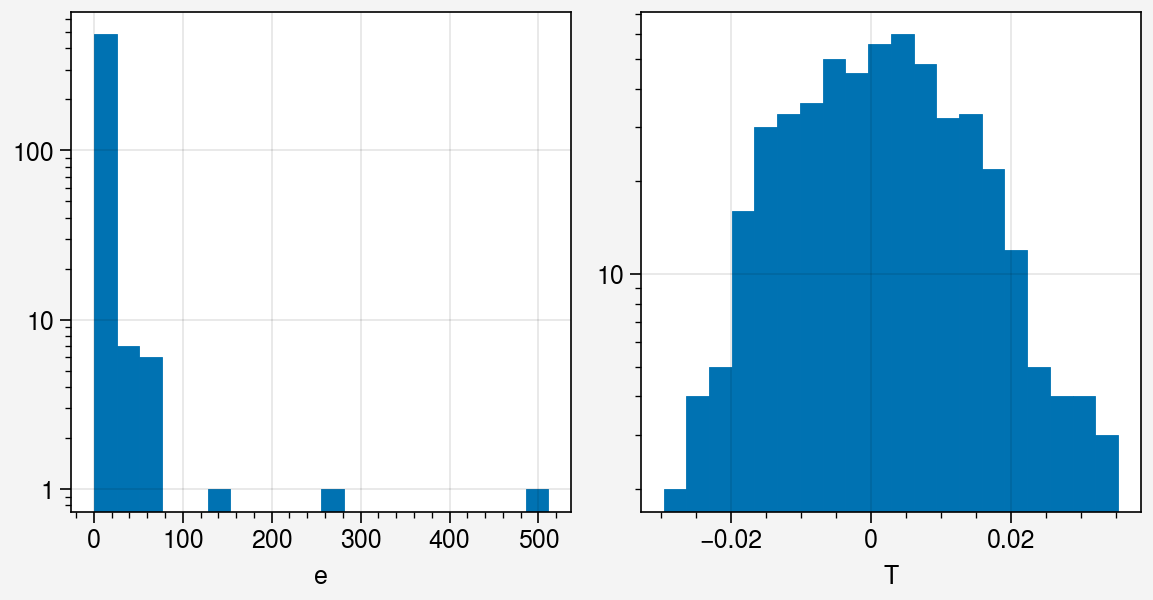

In [48]:
import ultraplot as uplt
import numpy as np

fig, axs = uplt.subplots(nrows=1, ncols=2, share=0)

# axs[0].hist(np.log10(1.0 + np.sqrt(moms[:, 2]**2 + moms[:, 3]**2)), bins=20, log=True)
# axs[0].format(xlabel="log10[1+ e]")

evals = np.sqrt(moms[:, 2]**2 + moms[:, 3]**2)
axs[0].hist(evals, bins=20, log=True)
axs[0].format(xlabel="e")

axs[1].hist(moms[:, 4], bins=20, log=True)
axs[1].format(xlabel="T")

In [29]:
import numpy as np

import ngmix

from admom_core import obs_to_ngmix_obs
from metadetect.fitting import fit_mbobs_gauss
from metadetect.procflags import get_procflags_str


In [32]:
%%time

mbobs = ngmix.MultiBandObsList()
for obs in obs_list:
    ng_obs = obs_to_ngmix_obs(obs)
    print("s/n:", ng_obs.get_s2n())
    ol = ngmix.ObsList()
    ol.append(obs_to_ngmix_obs(obs))
    mbobs.append(ol)

res = fit_mbobs_gauss(mbobs=mbobs, bmask_flags=0, rng=np.random.RandomState(42))

print(
    "mbobs    [e1,e2] T flags:",
    np.array(ngmix.shape.g1g2_to_e1e2(*res["gauss_g"][0])),
    res["gauss_T"][0],
    f"'{get_procflags_str(res['gauss_flags'])}'"
)


s/n: 2.8210892656188964
s/n: 5.418372757728079
s/n: 6.997508866023284
mbobs    [e1,e2] T flags: [-0.11488905  0.0117069 ] 0.3274981021263068 ''
CPU times: user 19.1 ms, sys: 2.81 ms, total: 21.9 ms
Wall time: 22.8 ms


In [7]:
from ngmix.shape import g1g2_to_e1e2
from ngmix.priors.shape import GPriorBA

gpr = GPriorBA(0.3, np.random.RandomState())
gvals = gpr.sample2d(10000)

evals = g1g2_to_e1e2(gvals[0], gvals[1])

(0.4068824470547512, 0.4050235994803206)

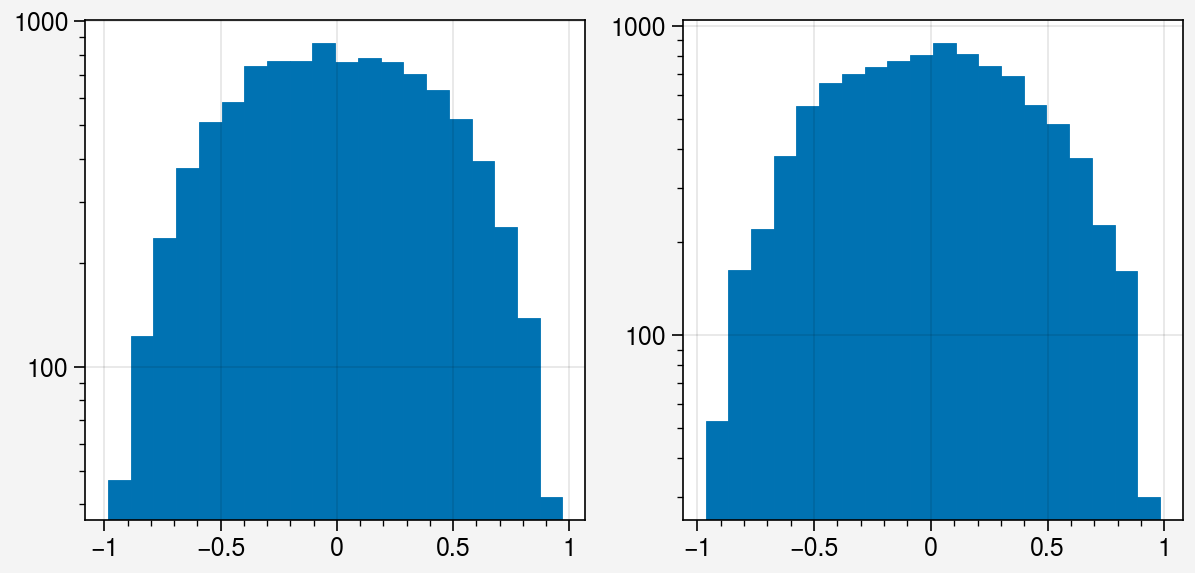

In [8]:
fig, axs = uplt.subplots(nrows=1, ncols=2, share=0)

axs[0].hist(evals[0], bins=20, log=True)
axs[1].hist(evals[1], bins=20, log=True)
np.std(evals[0]), np.std(evals[1])

0.14655362185861504 0.0594344879698039 0.4055477252356291


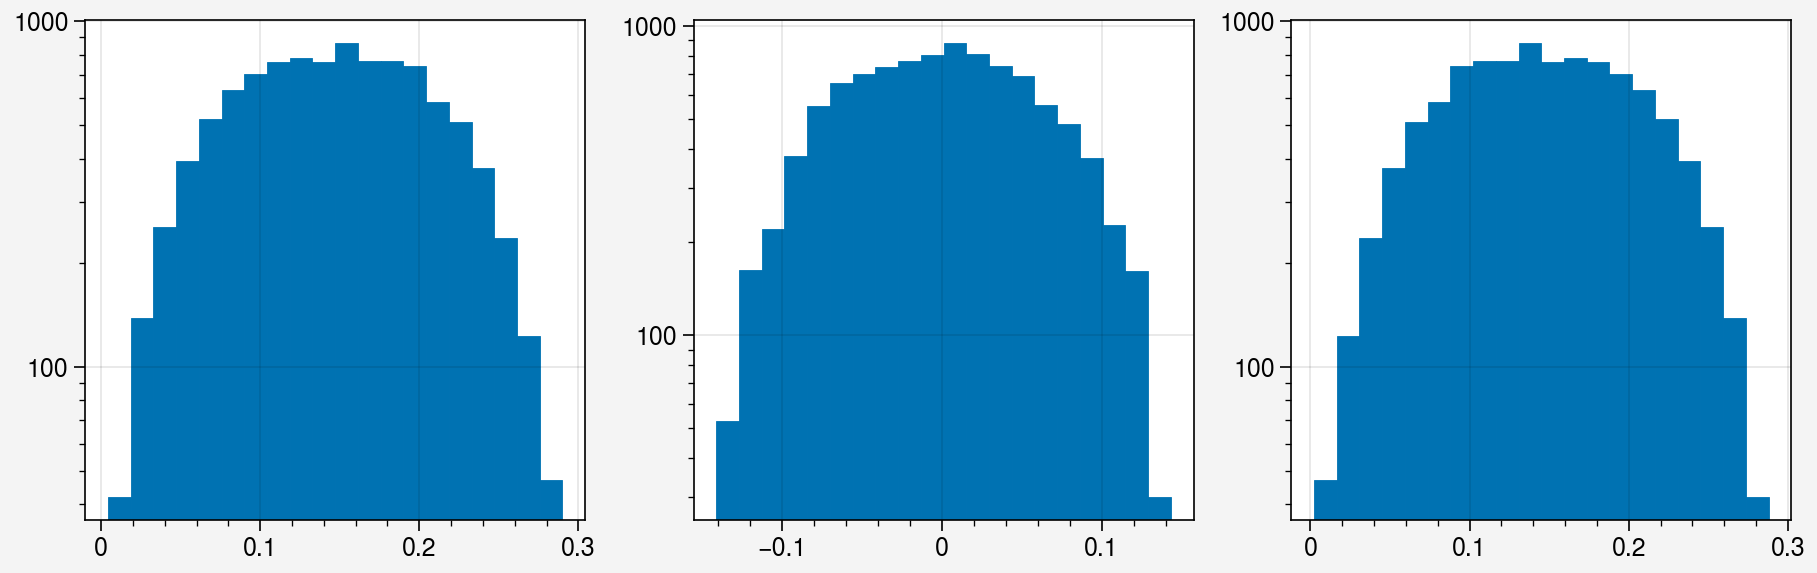

In [10]:
import ngmix.moments

irr, irc, icc = ngmix.moments.e2mom(evals[0], evals[1], ngmix.moments.fwhm_to_T(0.9))

fig, axs = uplt.subplots(nrows=1, ncols=3, share=0)

axs[0].hist(irr, bins=20, log=True)
axs[1].hist(irc, bins=20, log=True)
axs[2].hist(icc, bins=20, log=True)

print(np.mean(irr), np.std(irr), np.std(irr) / np.mean(irr))

In [11]:
import scipy.stats

In [125]:
target_T_2 = ngmix.moments.fwhm_to_T(0.9) / 2
df = 20

psi_val = target_T_2 * (df - 2 - 1)
psi_val = target_T_2 * (df + 2 + 1)
mn = psi_val / (df - 2 - 1) if df > 3 else np.nan
mode = psi_val / (df + 2 + 1)
# std = np.sqrt(2 * psi_val**2 / (df - 2 - 1) / (df - 2 - 1) / (df - 2 - 3))

print("T/2,mn,mode:", target_T_2, mn, mode)

T/2,mn,mode: 0.14607287289000756 0.19762800449824552 0.14607287289000756


mean exp|mes: 0.39525600899649105 0.39539473528526653
mode exp|mes: 0.2921457457800151 0.3434626299923589


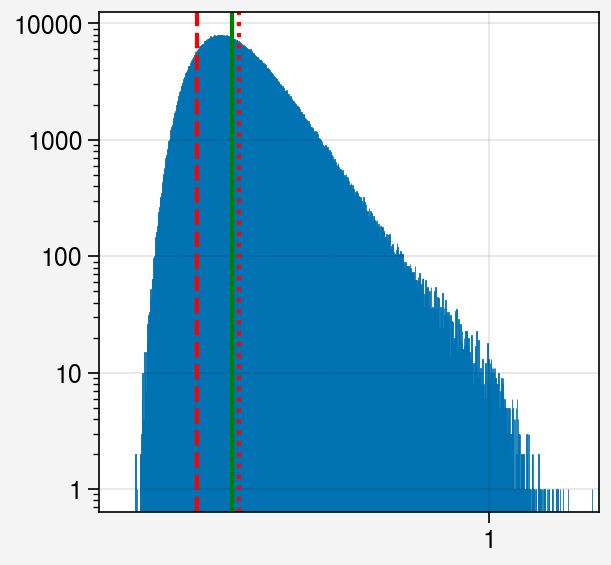

In [126]:
scale_mat = np.array(
    [[psi_val, 0.0], [0.0, psi_val]]
)

dst = scipy.stats.invwishart(df=df, scale=scale_mat)

draws = dst.rvs(1000000)
print("mean exp|mes:", mn * 2, np.mean(draws[:, 0, 0] + draws[:, 1, 1]))


fig, axs = uplt.subplots(nrows=1, ncols=1, share=0)

nb = 1000
bv, be, _, = axs.hist(draws[:, 0, 0] + draws[:, 1, 1], bins=nb, log=True)
axs.axvline(mode * 2, color="red", linestyle="--")
axs.axvline(mn * 2, color="red", linestyle=":")
axs.axvline(np.median(draws[:, 0, 0] + draws[:, 1, 1]), color="green")
print("mode exp|mes:", mode * 2, be[np.argmax(bv)])

axs.format(xscale="symlog")

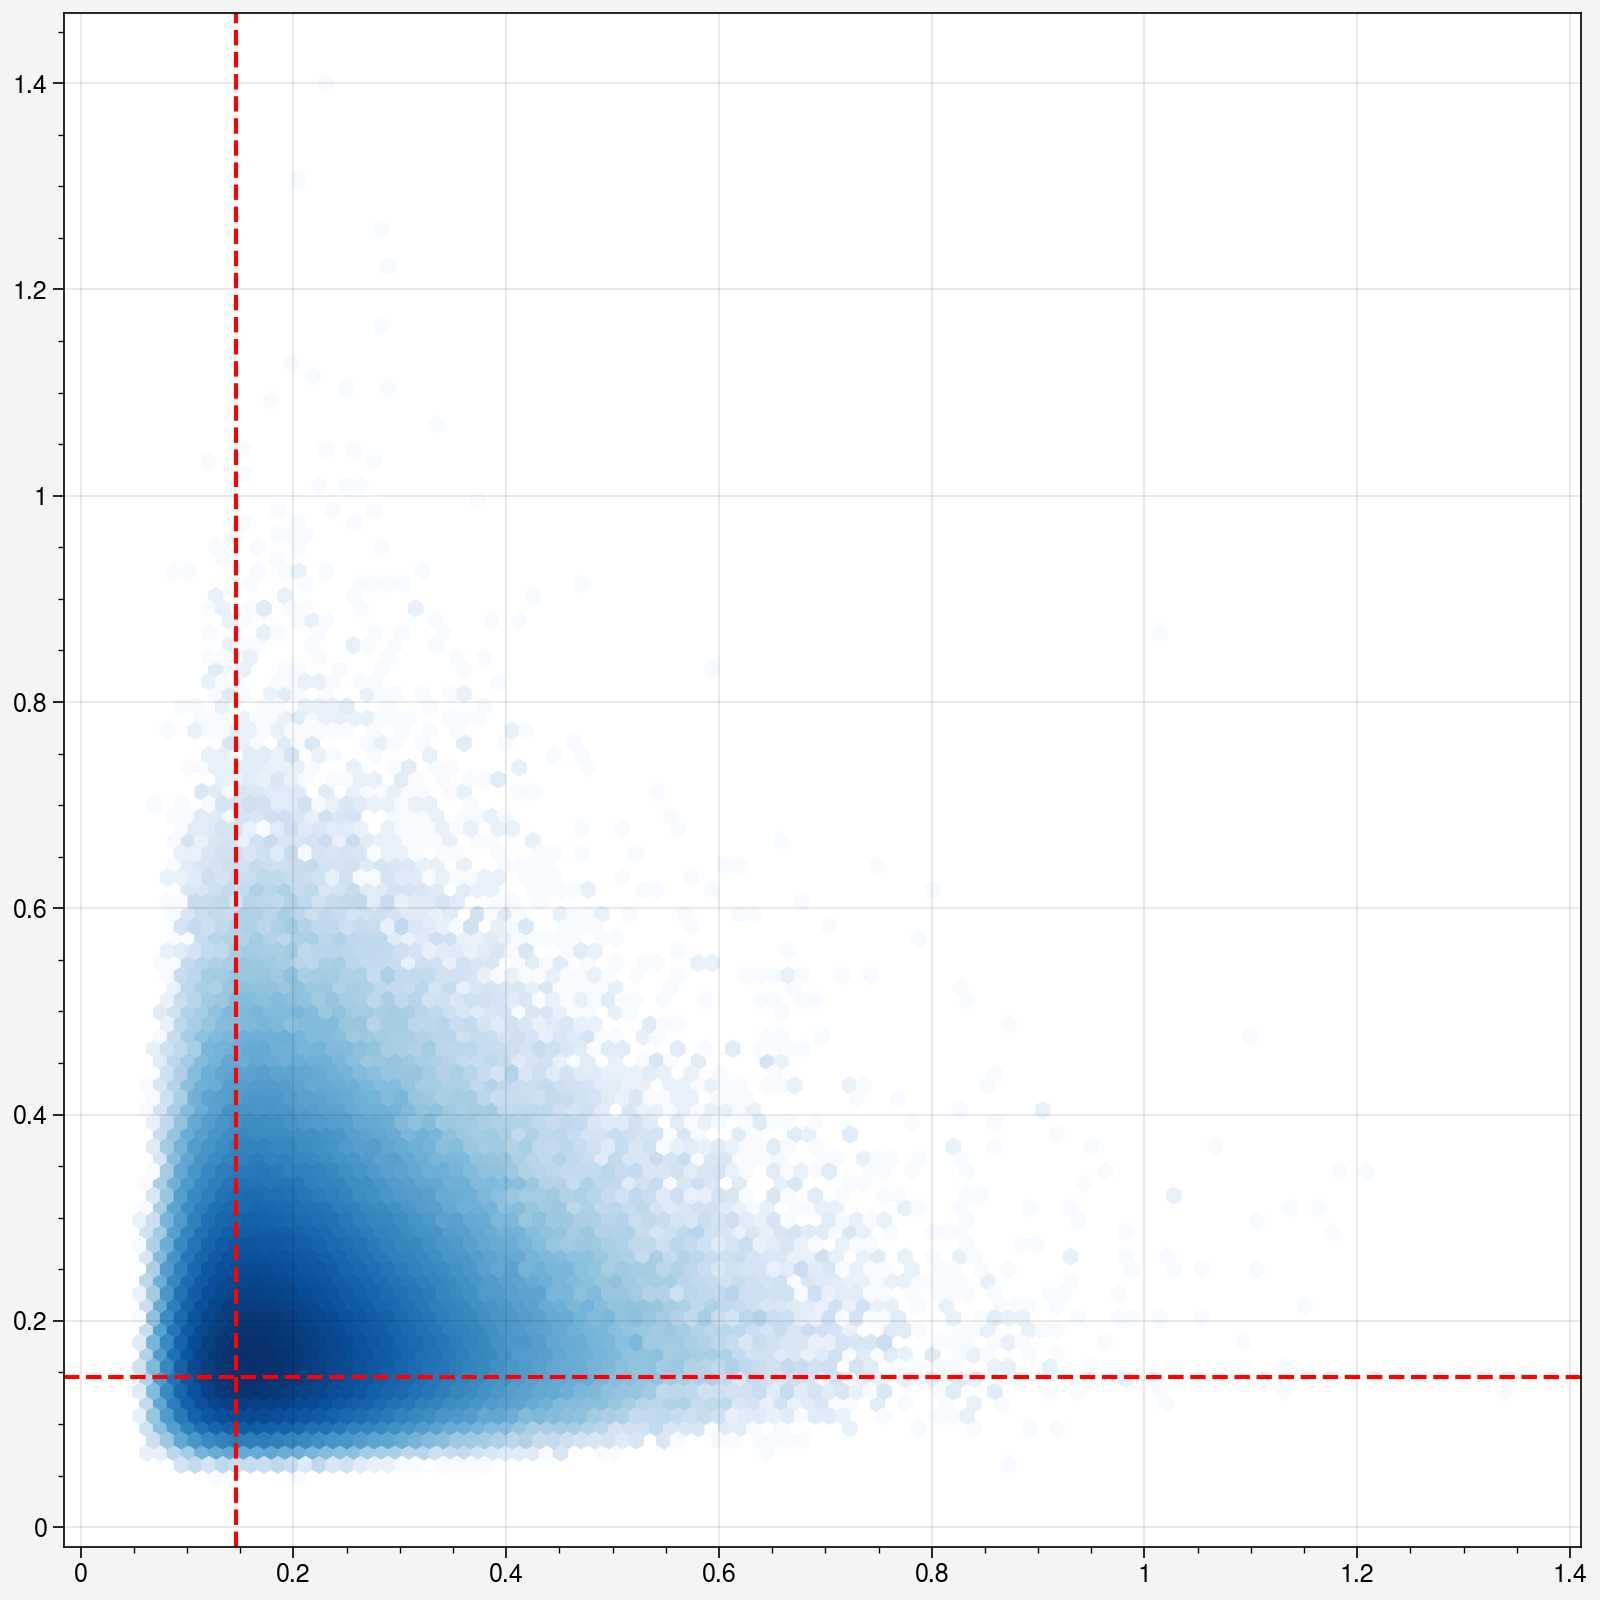

In [142]:
fig, axs = uplt.subplots(nrows=1, ncols=1, figsize=(8, 8))

axs.hexbin(
    draws[:, 0, 0],
    draws[:, 1, 1],
    gridsize=100,
    cmap="Blues",
    bins=None,
    norm="log",
)
axs.axvline(mode, color="red", linestyle="--")
axs.axhline(mode, color="red", linestyle="--")


In [90]:
scale_mat = np.array(
    [[psi_val, 0.0], [0.0, psi_val]]
)

dst = scipy.stats.invwishart(df=df, scale=scale_mat)
draws = dst.rvs(100000)
np.mean(draws, axis=0)

array([[ 1.46098730e-01, -2.40952497e-05],
       [-2.40952497e-05,  1.46244113e-01]])

0.21877296188061301 0.21829915246047957
0.2922562292292278 0.076822799429791 0.2921457457800151 -0.534400433494451


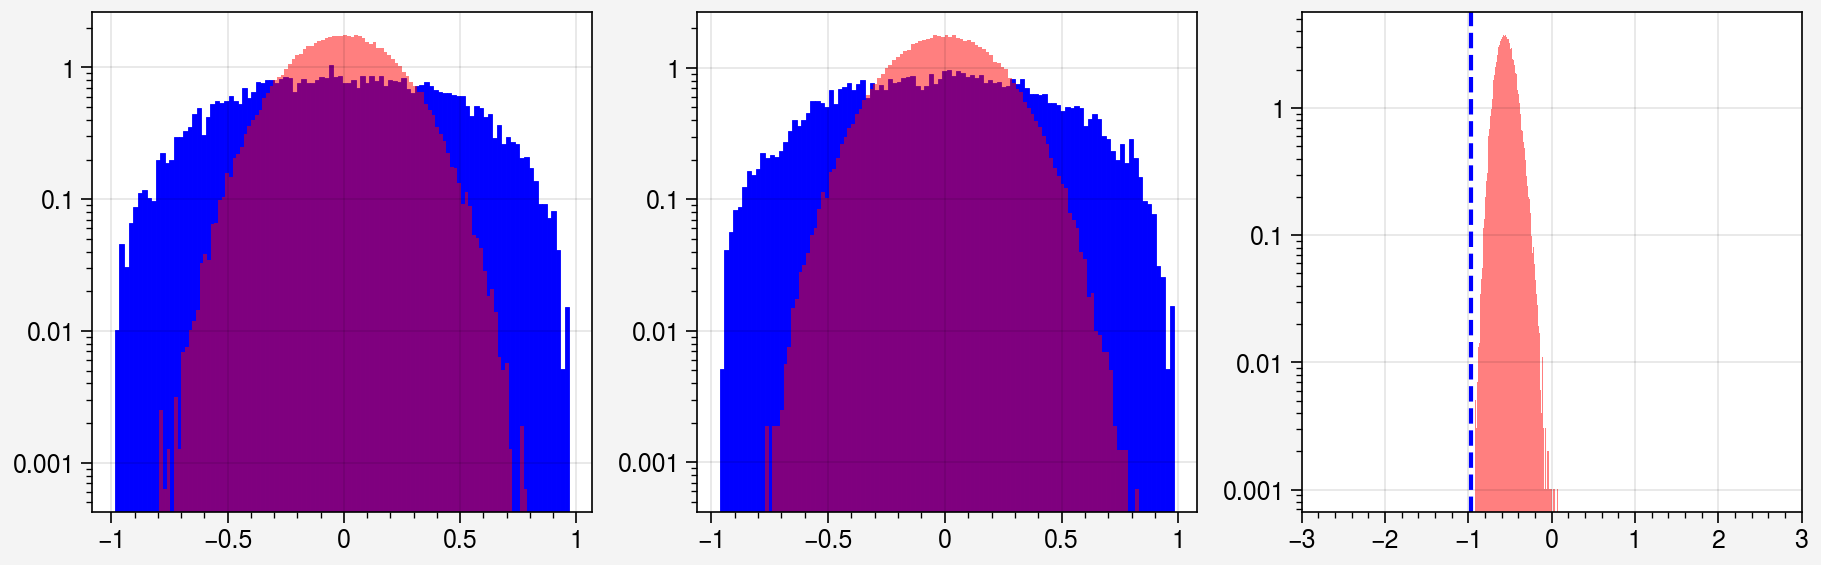

In [91]:
scale_mat = np.array(
    [[psi_val, 0.0], [0.0, psi_val]]
)

dst = scipy.stats.invwishart(df=df, scale=scale_mat)
draws = dst.rvs(100000)

ed1, ed2, td = ngmix.moments.mom2e(draws[:, 0, 0], draws[:, 0, 1], draws[:, 1, 1])
print(np.std(ed1), np.std(ed2))
print(np.mean(td), np.std(td), ngmix.moments.fwhm_to_T(0.9), np.log10(ngmix.moments.fwhm_to_T(0.9)))

fig, axs = uplt.subplots(nrows=1, ncols=3, share=0)

nb = 100
axs[0].hist(evals[0], bins=nb, log=True, density=True, color="blue")
axs[0].hist(ed1, bins=nb, log=True, density=True, alpha=0.5, color="red")
axs[1].hist(evals[1], bins=nb, log=True, density=True, color="blue")
axs[1].hist(ed2, bins=nb, log=True, density=True, alpha=0.5, color="red")
# axs[2].hist(tvals, bins=nb, log=True, density=True)
bv, be, _ = axs[2].hist(np.log10(td), bins=nb, log=True, density=True, alpha=0.5, color="red")
# axs[2].axvline(np.log10(ngmix.moments.fwhm_to_T(0.9)), color="blue", linestyle="--")
axs[2].axvline(np.log10(mode), color="blue", linestyle="--")
axs[2].format(xlim=(-3, 3))


In [86]:
10**be[np.argmax(bv)]

0.37105279681266656

0.9550545562989369

In [132]:
axs.hexbin?

Signature: axs.hexbin(*args, **kwargs)
Docstring:
ultraplot documentation

Plot a 2D hexagonally binned histogram.
standard 2D histogram.

Parameters
----------
*args : y or x, y
    The data passed as positional or keyword arguments. Interpreted as follows:

    * If only `y` coordinates are passed, try to infer the `x` coordinates
      from the `~pandas.Series` or `~pandas.DataFrame` indices or the
      `~xarray.DataArray` coordinates. Otherwise, the `x` coordinates
      are ``np.arange(0, y.shape[0])``.
    * If the `y` coordinates are a 2D array, plot each column of data in succession
      (except where each column of data represents a statistical distribution, as with
      ``boxplot``, ``violinplot``, or when using ``means=True`` or ``medians=True``).
    * If any arguments are `pint.Quantity`, auto-add the pint unit registry
      to matplotlib's unit registry using `~pint.UnitRegistry.setup_matplotlib`.
      A `pint.Quantity` embedded in an `xarray.DataArray` is also suppo